<a href="https://colab.research.google.com/github/Walt9819/factores-impacto-desempleo-mexico/blob/main/Python/AnalisisExploratorioNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NOTAS PERIODÍSTICAS LA JORNADA**

Análisis exploratorio de las notas periodísticas usando Procesamiento de Lenguaje Natural Básico

## Definición de módulos

In [ ]:
import pandas as pd
import locale
from datetime import datetime
import plotly.express as px
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import dateutil

### Extracción de notas periodísticas con Scrapy
Scrapy fue utilizado para rastrear el sitio web de La Jornada (se puede actualizar la programación hacia otro periodico) y extraer las noticias de manera eficiente sobre las palabras clave *'restaurantes'* y *'covid'*. Con el objetivo de analizar la conversación sobre unos de los sectores economicos mas afectados durante de la pandemia, con este análisis se logro corroborar que efectivamente el cierre y la reapertura fueron temas latentes durante durante el año 2020.  Los pasos que se siguieron para la extracción de las noticias fueron los siguientes:
1. Instalar los módulos scrapy y virtualenv:

> `pip install scrapy`

> `pip install virtualenv`

2. Se crea un ambiente virtual con Python y se activa:

```
$ virtualenv scrapyvenv
$ cd scrapyvenv
$ .\Scripts\activate
```
3. Se crea un proyecto Scrapy:

```
$ scrapy startproject webscrapy
```
4. Se crea una araña o spider:

```
$ cd webscrapy
$ scrapy genspider jornada www.imdb.com
```
5. Al terminar de codificar la araña, se ejecuta el siguiente comando para iniciar el proceso de extracción de información:

```
$ scrapy crawl jornada -a Keywords='restaurantes,covid' -o jornada.csv
```














## Exploración y trasformación inicial
1. Se leen el archivo CSV generado con la araña, el cual contiene el nombre del autor, el cuerpo de la nota periodística, la fecha de publicación, las palabras claves, el enlace, ubicación, la fuente de datos y el titulo de la noticia.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/jornada_restaurantes.csv')
data.head(10)

,author,body,date,keyWords,link,location,source,title
0,Redacción,"México, como muchos países está volviendo a re...","martes, 29 dic 2020 09:00","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,2020: Un año donde la diferencia la hicimos to...
1,"Héctor Briseño, Corresponsal","Acapulco, Gro., Los principales destinos turís...","lunes, 04 ene 2021 07:51","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,NaN,LaJornada.com,Cayó $3 mil millones la derrama turística dece...
2,Afp,Londres. La totalidad de los 56 millones de ha...,"jueves, 26 nov 2020 14:40","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres,LaJornada.com,Inglaterra mantendrá importantes restricciones...
3,"Afp, Ap y Sputnik",Los Ángeles. En su lucha por controlar cifras ...,"jueves, 26 nov 2020 08:01","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,NaN,LaJornada.com,Millón y medio de infectados en América en una...
4,Rocío González Alvarado,Sábado 28 de noviembre de 2020. Una de las apu...,"sábado, 28 nov 2020 08:24","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,NaN,LaJornada.com,"""Alerta al límite del rojo"" en la CDMX: Shein..."
5,Afp,Londres. Más de 60 personas fueron detenidas e...,"sábado, 28 nov 2020 15:33","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres.,LaJornada.com,Cientos protestan contra las restricciones Cov...
6,Josefina Quintero M.,Ciudad de México. La alerta al límite para pas...,"domingo, 29 nov 2020 08:16","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,Ciudad de México.,LaJornada.com,Nada frena las aglomeraciones en la CDMX
7,Alejandro Cruz Flores,Ciudad de México. El Gobierno de la Ciudad de ...,"lunes, 30 nov 2020 07:20","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,NaN,LaJornada.com,Sheinbaum refuerza las medidas contra aglomera...
8,Afp,"París. Europa, segunda región del mundo más en...","sábado, 28 nov 2020 15:11","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,NaN,LaJornada.com,Supera Europa 400 mil muertos por Covid-19
9,Reuters,Tokio. Tokio elevó el jueves al nivel máximo s...,"jueves, 19 nov 2020 14:15","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Tokio.,LaJornada.com,Eleva Tokio a nivel máximo su alerta sanitaria...


2. Se reemplazan los acronimos de los meses al idioma Ingles, para que el parser del modulo dateutil reconozca la fecha en el texto de manera automatica y se pueda convertir el string a un formato datetime.

In [ ]:
data['date'] = data['date'].str.replace(r'ago', 'aug')
data['date'] = data['date'].str.replace(r'abr', 'apr')
data['date'] = data['date'].str.replace(r'ene', 'jan')
data['date'] = data['date'].str.replace(r'dic', 'dec')
data['date'] = [dateutil.parser.parse(x, fuzzy_with_tokens=True)[0] for x in data['date']]
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month

3. Se corrobora la transformación del atributo date y los nuevos atributos agregados al dataframe.

In [ ]:
data

,author,body,date,keyWords,link,location,source,title,year,month
0,Redacción,"México, como muchos países está volviendo a re...",2020-12-29 09:00:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,2020: Un año donde la diferencia la hicimos to...,2020,12
1,"Héctor Briseño, Corresponsal","Acapulco, Gro., Los principales destinos turís...",2021-01-04 07:51:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,NaN,LaJornada.com,Cayó $3 mil millones la derrama turística dece...,2021,1
2,Afp,Londres. La totalidad de los 56 millones de ha...,2020-11-26 14:40:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres,LaJornada.com,Inglaterra mantendrá importantes restricciones...,2020,11
3,"Afp, Ap y Sputnik",Los Ángeles. En su lucha por controlar cifras ...,2020-11-26 08:01:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,NaN,LaJornada.com,Millón y medio de infectados en América en una...,2020,11
4,Rocío González Alvarado,Sábado 28 de noviembre de 2020. Una de las apu...,2020-11-28 08:24:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,NaN,LaJornada.com,"""Alerta al límite del rojo"" en la CDMX: Shein...",2020,11
...,...,...,...,...,...,...,...,...,...,...
639,Néstor Jiménez y Alonso Urrutia,Ciudad de México. México es autosuficientes en...,2020-03-31 09:13:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,Multas de hasta 3 mdp por alzas irregulares en...,2020,3
640,Carlos Águila Arreola/ La Jornada Maya,"Cancún. Los cines, bares, discotecas, casinos ...",2020-03-18 20:03:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,Cancún,LaJornada.com,Cancún cerrará todo giro comercial para evitar...,2020,3
641,Lilián Anaya @Lilian_Anaya,Ciudad de México. Uber Eats informó que une es...,2020-03-23 16:00:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/tiempo-de-i...,Ciudad de México,LaJornada.com,"Uber Eats apoya a restaurantes, repartidores y...",2020,3
642,Ap,La Habana. Un millar de cruceristas y la tripu...,2020-03-18 15:40:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,La Habana.,LaJornada.com,Desembarcan en Cuba pasajeros de crucero recha...,2020,3


4. Se cuentan los números de registros extraídos por año

In [ ]:
count_year = data.groupby('year').count()[['link']].reset_index().rename(columns={'link': 'count'})
count_year

,year,count
0,2020,643
1,2021,1


5. Al identificar que del año 2021 se extrajo una sola nota, se procede a eliminar para hacer un análisis en el año del interes.

In [ ]:
mask = (data['year'] == 2020)
data = data.loc[mask]
data.shape

(643, 10)

6. Con esta modificación, se procede a analizar en cuales meses se cuenta con mayor número de noticias ejecutando un group by y conteo por enlace (link).

In [ ]:
count_month = data.groupby('month').count()[['link']].reset_index().rename(columns={'link': 'count'})
count_month

,month,count
0,2,2
1,3,98
2,4,62
3,5,106
4,6,91
5,7,76
6,8,31
7,9,41
8,10,82
9,11,53


7. Se logra identificar una alza el número de notas periodisticas sobre los restaurantes en los meses de Marzo y Mayo, cuando al inicio de la pandemia el 22 de Marzo en la Ciudad de México se anunciaron las nuevas medidas para evitar el contagio. En el mes de Mayo, se debe por la baja demanda de restaurantes o eventos relativos al día de las madres.

In [ ]:
fig = px.bar(count_month, x="month", y="count")
fig.show()

In [ ]:
data_month = data.groupby(['month'])['body'].apply(' '.join).reset_index()
data_month = data_month.set_index('month')
data_month

,body
month,
2,Seúl. Corea del Norte anunció un arsenal de me...
3,"Mérida, Yuc. Para disminuir en todo lo posible..."
4,"Teotihuacán, Méx. Un grupo de comerciantes y a..."
5,Berlín. Alemania prolongará hasta el 29 de jun...
6,Ciudad de México. De los 121 mil 765 estableci...
7,Lima. El gobierno peruano informó este miércol...
8,Londres. Las medidas para evitar la propagació...
9,Ciudad de México. Dirigentes de asociaciones d...
10,Bruselas. Bélgica impondrá reglas de confinami...


In [ ]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
 
round1 = lambda x: clean_text_round1(x)
 
data_clean = pd.DataFrame(data_month.body.apply(round1))
 
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
 
round2 = lambda x: clean_text_round2(x)
 
data_clean = pd.DataFrame(data_clean.body.apply(round2))
data_clean
 
# Let's pickle it for later use
# data_month.to_pickle("corpus.pkl")

,body
month,
2,seúl corea del norte anunció un arsenal de me...
3,mérida yuc para disminuir en todo lo posible...
4,teotihuacán méx un grupo de comerciantes y a...
5,berlín alemania prolongará hasta el de junio...
6,ciudad de méxico de los mil establecimiento...
7,lima el gobierno peruano informó este miércol...
8,londres las medidas para evitar la propagació...
9,ciudad de méxico dirigentes de asociaciones d...
10,bruselas bélgica impondrá reglas de confinami...


In [ ]:
import base64
import requests

master = "https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/spanish.txt"
req = requests.get(master)
lines = req.text.split(sep='\n')
#print(req)

In [ ]:
cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(data_clean.body)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
 
#data_dtm.to_pickle("dtm.pkl")
# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
#data_clean.to_pickle('data_clean.pkl')
#pickle.dump(cv, open("cv.pkl", "wb"))
 
data_dtm

,abad,abajo,abandonados,abandonando,abandonar,abandonaron,abandonen,abandonó,abanico,abaratamiento,abarca,abarrotadas,abarrotado,abarrotados,abarrotaron,abarrotará,abarrotes,abarrotó,abascal,abasolo,abastecedor,abastecen,abastecer,abastecerse,abastecimiento,abasto,abastos,abatir,abbot,abbott,abc,abdo,abdool,abdulá,abel,abelardo,abierta,abiertamente,abiertas,abierto,...,ésto,éstos,étnico,éxito,éxodo,íbamos,índice,índices,índico,íntegro,íñigo,ópera,ópticas,óptimas,óptimo,órdenes,órgano,órganos,óscar,última,últimas,último,últimos,única,únicamente,únicas,único,únicos,úrkullu,útil,útiles,𝐋𝐢𝐧𝐞𝐚𝐦𝐢𝐞𝐧𝐭𝐨,𝐍𝐚𝐜𝐢𝐨𝐧𝐚𝐥,𝐑𝐞𝐚𝐩𝐞𝐫𝐭𝐮𝐫𝐚,𝐒𝐞𝐜𝐭𝐨𝐫,𝐓𝐮𝐫𝐢,𝐝𝐞𝐥,𝐥𝐚,𝐩𝐚𝐫𝐚,𝐬𝐭𝐢𝐜𝐨
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,0,5,0,0,0,0,0,0,1,0,9,1,0,0,0,0,0,0,0,0,0,1,0,3,3,...,0,1,2,3,0,0,1,0,0,1,2,0,0,1,0,2,1,4,1,11,10,10,11,3,4,0,3,0,2,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,2,0,0,1,0,1,0,0,0,12,0,0,0,0,0,2,0,0,8,0,0,0,1,0,0,0,0,2,1,1,0,1,1,...,0,3,0,0,1,1,2,0,0,0,0,0,0,0,0,3,0,0,1,4,7,9,4,0,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,2,7,...,0,0,0,4,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,2,33,12,13,3,6,0,2,1,0,0,0,1,1,1,1,1,1,1,1,1
6,0,2,0,0,2,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,1,0,3,6,...,1,1,0,2,0,1,2,2,1,0,0,0,0,1,0,4,0,1,0,4,15,8,13,1,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,0,1,1,2,1,...,0,2,0,1,0,0,2,1,0,0,0,0,2,0,0,1,0,0,0,4,14,6,6,4,4,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,1,2,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,3,3,3,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,4,9,2,7,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,8,2,...,0,2,0,1,0,2,4,1,0,0,0,2,0,1,1,1,0,0,0,8,21,11,17,1,2,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
dt_data = data_dtm.transpose()
dt_data.head()

month,2,3,4,5,6,7,8,9,10,11,12
abad,0,0,0,1,0,0,0,0,0,0,0
abajo,0,0,0,0,2,1,0,0,0,0,0
abandonados,0,1,1,0,0,0,0,0,0,0,0
abandonando,0,0,0,0,0,0,1,0,0,0,0
abandonar,0,1,1,1,2,1,0,0,0,1,0


In [ ]:
top_dict = {}
for c in dt_data.columns:
    top = dt_data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
#print(top_dict)
# Print the top 15 words by year
for month, top_words in top_dict.items():
    print(month)
    print(', '.join([word+' '+str(count) for word, count in top_words[0:14]]))

2
coronavirus 10, país 9, irán 6, casos 6, países 6, corea 6, ahora 5, según 5, irak 5, norte 5, china 5, hadj 5, saudita 5, año 5
3
mil 237, covid 182, país 159, medidas 152, restaurantes 147, personas 147, gobierno 141, ciudad 139, méxico 130, salud 128, coronavirus 115, casos 112, ciento 108, pandemia 88
4
mil 179, covid 115, personas 96, pandemia 90, gobierno 88, millones 86, restaurantes 82, país 79, salud 79, coronavirus 77, méxico 73, medidas 71, ciento 63, ciudad 63
5
mil 454, covid 236, coronavirus 221, pandemia 192, ciento 166, país 144, millones 144, dos 141, restaurantes 140, personas 130, medidas 124, muertos 122, mayo 121, gobierno 119
6
ciento 242, mil 236, covid 149, restaurantes 132, casos 117, medidas 115, actividades 109, méxico 109, personas 104, pandemia 104, coronavirus 95, dijo 93, semáforo 90, ciudad 82
7
mil 194, ciento 171, covid 137, ciudad 135, méxico 132, restaurantes 124, casos 115, personas 109, pandemia 98, medidas 98, país 80, millones 77, contagios 75,

In [ ]:
from collections import Counter

# Let's first pull out the top 30 words for each anio
words = []
for anio in dt_data.columns:
    top = [word for (word, count) in top_dict[anio]]
    for t in top:
        words.append(t)
print(Counter(words).most_common())
add_stop_words = [word for word, count in Counter(words).most_common() if count > 6]
add_stop_words

[('país', 11), ('casos', 10), ('mil', 10), ('covid', 10), ('personas', 10), ('méxico', 10), ('millones', 10), ('coronavirus', 9), ('medidas', 9), ('restaurantes', 9), ('gobierno', 9), ('ciudad', 9), ('salud', 9), ('ciento', 9), ('pandemia', 9), ('contagios', 8), ('dijo', 7), ('número', 6), ('actividades', 6), ('según', 5), ('autoridades', 4), ('parte', 4), ('días', 4), ('semana', 4), ('dos', 4), ('si', 4), ('año', 3), ('turismo', 3), ('cierre', 3), ('así', 3), ('mientras', 3), ('sector', 3), ('menos', 3), ('lunes', 3), ('restricciones', 3), ('países', 2), ('nuevo', 2), ('centros', 2), ('virus', 2), ('servicios', 2), ('crisis', 2), ('empresas', 2), ('meses', 2), ('mundo', 2), ('europa', 2), ('reapertura', 2), ('negocios', 2), ('mayor', 2), ('horas', 2), ('bares', 2), ('confinamiento', 2), ('irán', 1), ('corea', 1), ('ahora', 1), ('irak', 1), ('norte', 1), ('china', 1), ('hadj', 1), ('saudita', 1), ('embajador', 1), ('embajada', 1), ('ciudades', 1), ('religioso', 1), ('peregrinos', 1), (

['país',
 'casos',
 'mil',
 'covid',
 'personas',
 'méxico',
 'millones',
 'coronavirus',
 'medidas',
 'restaurantes',
 'gobierno',
 'ciudad',
 'salud',
 'ciento',
 'pandemia',
 'contagios',
 'dijo']

In [ ]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
# data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
stop_words = req.text.split(sep='\n')
for pal in add_stop_words:
    stop_words.append(pal)
more_stop_words=['día','nuevo','según','si','hora','año','function', 'recomendamos', 'west', 'texas wti', 'además', 'intermediate', 'display','ad','gpt','dijo','div','más','también', 'interarticle','pues','parte','está', 'cmd', 'push', 'googletag','alex','lucas','andrés','mirta','tres','primer','primera','dos','uno','veces', 'así', 'luego', 'quizá','cosa','cosas','tan','asi','andres','todas','sólo','jesús','pablo','pepe']
for pal in more_stop_words:
    stop_words.append(pal)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.body)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
#import pickle
#pickle.dump(cv, open("cv_stop.pkl", "wb"))
#data_stop.to_pickle("dtm_stop.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['texas', 'wti'] not in stop_words.



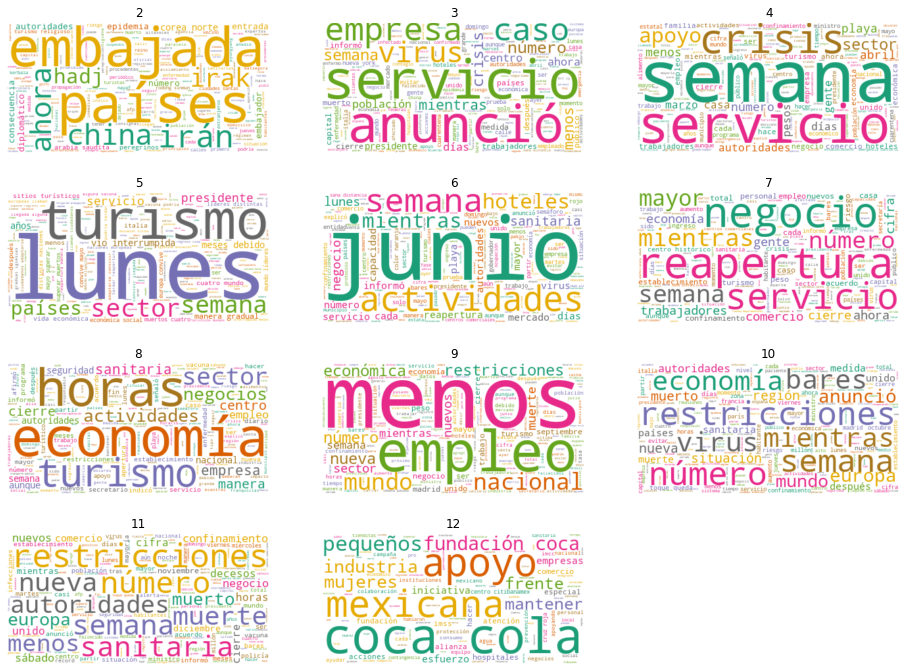

In [ ]:
from wordcloud import WordCloud
anios = ['2','3','4','5','6','7','8','9','10','11','12']

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,12]

# Create subplots for each anio
for index, mes in enumerate(dt_data.columns):
    wc.generate(data_clean.body[mes])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(anios[index])
plt.show()

# **Análisis de sentimientos**
Para cada noticia se analiza su polaridad y subjetividad, la primera asigna un valor positivo o negativo dependiendo del sentimiento identificado. 

# ADVERTENCIA: Este fragmento del código tarda debido a la traducción al idioma inglés con el modulo textblob.

In [ ]:
import nltk
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
pol2 = lambda x: x.sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
sub2 = lambda x: x.sentiment.subjectivity

traducir = lambda x: TextBlob(x).translate(to="en")

data['blob_en'] = data['body'].apply(traducir)
data['polarity'] = data['blob_en'].apply(pol2)
data['subjectivity'] = data['blob_en'].apply(sub2)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,author,body,date,keyWords,link,location,source,title,year,month,blob_en,polarity,subjectivity
0,Redacción,"México, como muchos países está volviendo a re...",2020-12-29 09:00:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,2020: Un año donde la diferencia la hicimos to...,2020,12,"(M, e, x, i, c, o, ,, , l, i, k, e, , m, a, ...",0.124086,0.317400
2,Afp,Londres. La totalidad de los 56 millones de ha...,2020-11-26 14:40:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres,LaJornada.com,Inglaterra mantendrá importantes restricciones...,2020,11,"(L, o, n, d, o, n, ., , T, h, e, , e, n, t, ...",0.101292,0.413893
3,"Afp, Ap y Sputnik",Los Ángeles. En su lucha por controlar cifras ...,2020-11-26 08:01:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,NaN,LaJornada.com,Millón y medio de infectados en América en una...,2020,11,"(T, h, e, , A, n, g, e, l, s, ., , I, n, , ...",0.055917,0.354411
4,Rocío González Alvarado,Sábado 28 de noviembre de 2020. Una de las apu...,2020-11-28 08:24:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,NaN,LaJornada.com,"""Alerta al límite del rojo"" en la CDMX: Shein...",2020,11,"(S, a, t, u, r, d, a, y, , N, o, v, e, m, b, ...",0.085129,0.379125
5,Afp,Londres. Más de 60 personas fueron detenidas e...,2020-11-28 15:33:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres.,LaJornada.com,Cientos protestan contra las restricciones Cov...,2020,11,"(L, o, n, d, o, n, ., , M, o, r, e, , t, h, ...",0.079821,0.278444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,Néstor Jiménez y Alonso Urrutia,Ciudad de México. México es autosuficientes en...,2020-03-31 09:13:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,Multas de hasta 3 mdp por alzas irregulares en...,2020,3,"(M, e, x, i, c, o, , C, i, t, y, ., , M, e, ...",0.014323,0.327404
640,Carlos Águila Arreola/ La Jornada Maya,"Cancún. Los cines, bares, discotecas, casinos ...",2020-03-18 20:03:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,Cancún,LaJornada.com,Cancún cerrará todo giro comercial para evitar...,2020,3,"(C, a, n, c, u, n, ., , T, h, e, , c, i, n, ...",0.131190,0.402234
641,Lilián Anaya @Lilian_Anaya,Ciudad de México. Uber Eats informó que une es...,2020-03-23 16:00:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/tiempo-de-i...,Ciudad de México,LaJornada.com,"Uber Eats apoya a restaurantes, repartidores y...",2020,3,"(M, e, x, i, c, o, , C, i, t, y, ., , U, b, ...",0.067333,0.382048
642,Ap,La Habana. Un millar de cruceristas y la tripu...,2020-03-18 15:40:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,La Habana.,LaJornada.com,Desembarcan en Cuba pasajeros de crucero recha...,2020,3,"(H, a, v, a, n, a, ., , A, , t, h, o, u, s, ...",0.185659,0.312875


In [ ]:
data.to_csv('translated_news.csv')

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/translated_news.csv')
data

,Unnamed: 0,author,body,date,keyWords,link,location,source,title,year,month,blob_en,polarity,subjectivity
0,0,Redacción,"México, como muchos países está volviendo a re...",2020-12-29 09:00:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,2020: Un año donde la diferencia la hicimos to...,2020,12,"Mexico, like many countries, is gradually retu...",0.124086,0.317400
1,2,Afp,Londres. La totalidad de los 56 millones de ha...,2020-11-26 14:40:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres,LaJornada.com,Inglaterra mantendrá importantes restricciones...,2020,11,London. The entire 56 million inhabitants of E...,0.101292,0.413893
2,3,"Afp, Ap y Sputnik",Los Ángeles. En su lucha por controlar cifras ...,2020-11-26 08:01:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,NaN,LaJornada.com,Millón y medio de infectados en América en una...,2020,11,The Angels. In their struggle to control histo...,0.055917,0.354411
3,4,Rocío González Alvarado,Sábado 28 de noviembre de 2020. Una de las apu...,2020-11-28 08:24:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,NaN,LaJornada.com,"""Alerta al límite del rojo"" en la CDMX: Shein...",2020,11,"Saturday November 28, 2020. One of the capital...",0.085129,0.379125
4,5,Afp,Londres. Más de 60 personas fueron detenidas e...,2020-11-28 15:33:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres.,LaJornada.com,Cientos protestan contra las restricciones Cov...,2020,11,London. More than 60 people were arrested this...,0.079821,0.278444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,639,Néstor Jiménez y Alonso Urrutia,Ciudad de México. México es autosuficientes en...,2020-03-31 09:13:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,Multas de hasta 3 mdp por alzas irregulares en...,2020,3,Mexico City. Mexico is self-sufficient in whit...,0.014323,0.327404
639,640,Carlos Águila Arreola/ La Jornada Maya,"Cancún. Los cines, bares, discotecas, casinos ...",2020-03-18 20:03:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,Cancún,LaJornada.com,Cancún cerrará todo giro comercial para evitar...,2020,3,"Cancun. The cinemas, bars, discos, casinos and...",0.131190,0.402234
640,641,Lilián Anaya @Lilian_Anaya,Ciudad de México. Uber Eats informó que une es...,2020-03-23 16:00:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/tiempo-de-i...,Ciudad de México,LaJornada.com,"Uber Eats apoya a restaurantes, repartidores y...",2020,3,Mexico City. Uber Eats reported that it joins ...,0.067333,0.382048
641,642,Ap,La Habana. Un millar de cruceristas y la tripu...,2020-03-18 15:40:00,"'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,La Habana.,LaJornada.com,Desembarcan en Cuba pasajeros de crucero recha...,2020,3,Havana. A thousand cruise passengers and the c...,0.185659,0.312875


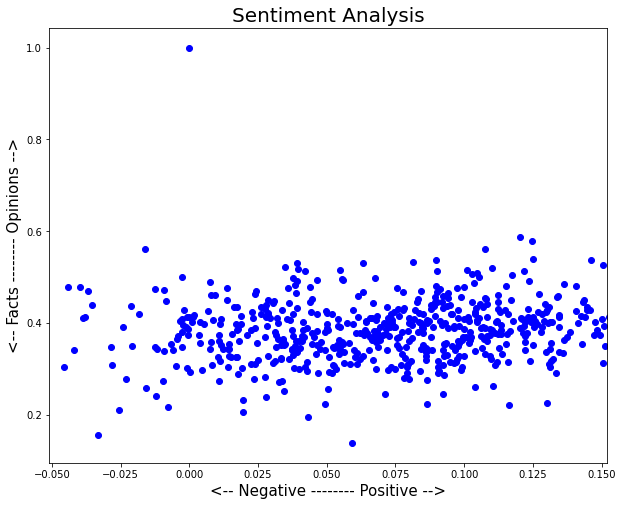

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, anio in enumerate(data.index):
    x = data.polarity.loc[anio]
    y = data.subjectivity.loc[anio]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data['full_name'][index], fontsize=10)
    plt.xlim(-0.051, 0.152) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()